<a href="https://colab.research.google.com/github/rom-chill/ggdaming/blob/main/daming_gg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn folium geopandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import folium
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime

# Agar plot tampil langsung di notebook
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

# Membaca file CSV yang sudah di-upload
df = pd.read_csv('kasi_slow_673.csv')

Saving kasi_slow_673.csv to kasi_slow_673.csv


In [ ]:
# Tampilkan 5 baris awal data
print(df.head())

# Informasi data
print(df.info())

# Statistik deskriptif
print(df.describe())

   kapal_id  latitude   longitude            timestamp  intensity  \
0  IMO-9179 -6.978624  110.374318  2025-05-11 19:57:00          5   
1  IMO-7482 -6.866963  110.306867  2025-05-13 16:10:00          9   
2  IMO-8517 -6.487924  110.411702  2025-05-23 02:12:00         17   
3  IMO-3340 -6.774290  110.869599  2025-05-10 18:00:00          9   
4  IMO-5339 -6.690085  110.480995  2025-05-25 12:59:00         11   

  jenis_operasi jenis_ikan  suhu_laut_c  kecepatan_angin_mps  
0  Pukat Cincin   Cakalang         26.9                  8.2  
1  Pukat Cincin    Bandeng         30.5                  2.6  
2       Gillnet   Cakalang         28.9                  6.9  
3         Rawai    Tongkol         28.0                  3.1  
4       Gillnet    Tongkol         28.3                  1.9  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0 

In [ ]:
# Cek nilai yang hilang
print("Missing values:\n", df.isnull().sum())

# Hapus duplikasi (jika ada)
df = df.drop_duplicates()

# Konversi kolom 'timestamp' menjadi tipe datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Pastikan tipe data sudah benar
print(df.dtypes)

Missing values:
 kapal_id               0
latitude               0
longitude              0
timestamp              0
intensity              0
jenis_operasi          0
jenis_ikan             0
suhu_laut_c            0
kecepatan_angin_mps    0
dtype: int64
kapal_id                       object
latitude                      float64
longitude                     float64
timestamp              datetime64[ns]
intensity                       int64
jenis_operasi                  object
jenis_ikan                     object
suhu_laut_c                   float64
kecepatan_angin_mps           float64
dtype: object


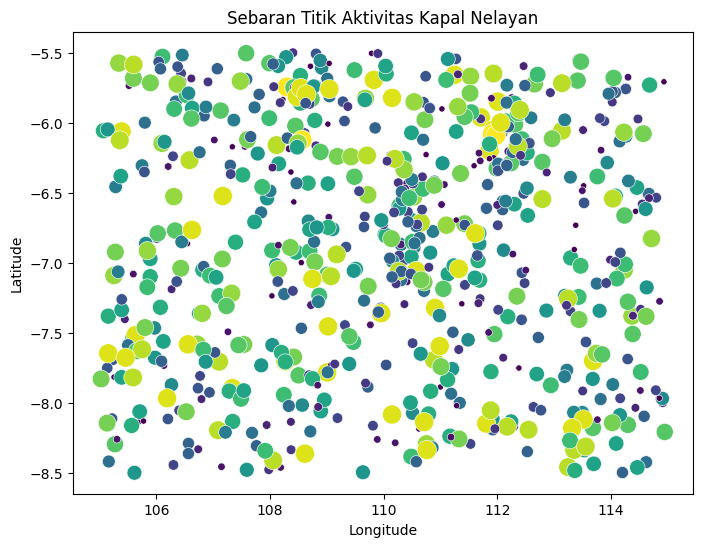

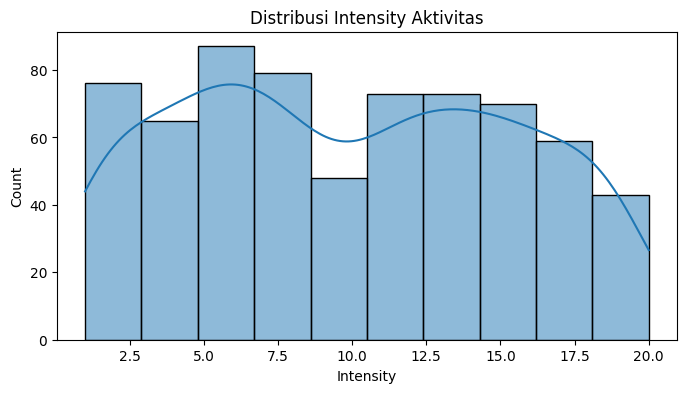

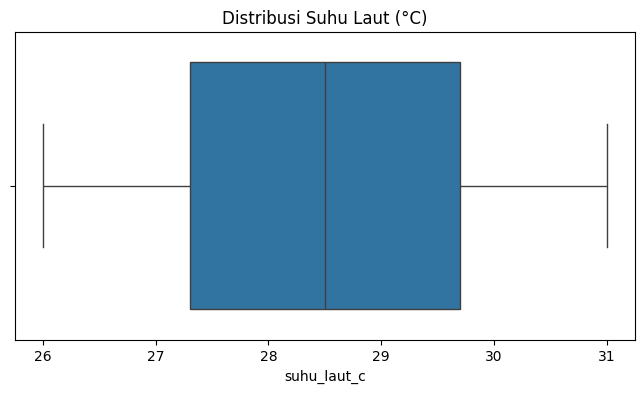

In [ ]:
# Scatter plot sebaran titik aktivitas kapal berdasarkan koordinat, ukuran berdasarkan intensity
plt.figure(figsize=(8,6))
sns.scatterplot(x='longitude', y='latitude', data=df, size='intensity', sizes=(20,200),
                hue='intensity', palette='viridis', legend=False)
plt.title('Sebaran Titik Aktivitas Kapal Nelayan')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Histogram distribusi Intensity
plt.figure(figsize=(8,4))
sns.histplot(df['intensity'], bins=10, kde=True)
plt.title('Distribusi Intensity Aktivitas')
plt.xlabel('Intensity')
plt.show()

# Boxplot distribusi Suhu Laut
plt.figure(figsize=(8,4))
sns.boxplot(x=df['suhu_laut_c'])
plt.title('Distribusi Suhu Laut (°C)')
plt.show()

In [ ]:
# Ubah DataFrame menjadi GeoDataFrame dengan kolom 'geometry'
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df['longitude'], df['latitude'])],
    crs="EPSG:4326"
)

# Download file ZIP shapefile menggunakan wget dan simpan sebagai 'countries.zip'
!wget -q "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip" -O countries.zip

# Baca file ZIP lokal dengan GeoPandas
world = gpd.read_file("zip://countries.zip")

# Filter poligon untuk mendapatkan wilayah Indonesia.
# Perhatikan bahwa pada dataset ini kolom nama negara adalah 'NAME'
indonesia = world[world['NAME'] == 'Indonesia']

# Lakukan spatial join untuk mendeteksi titik yang berada di daratan Indonesia.
# Menggunakan parameter 'predicate' (untuk versi GeoPandas terbaru) dengan nilai 'within'
points_on_land = gpd.sjoin(gdf, indonesia, predicate='within', how='inner')
print("Jumlah titik di daratan:", points_on_land.shape[0])

# Buat GeoDataFrame bersih dengan menghapus titik yang berada di daratan
gdf_clean = gdf[~gdf.index.isin(points_on_land.index)]
print("Jumlah titik setelah filtering (hanya perairan):", gdf_clean.shape[0])

Jumlah titik di daratan: 220
Jumlah titik setelah filtering (hanya perairan): 453


In [ ]:
# Pilih fitur untuk clustering
features = gdf_clean[['latitude', 'longitude', 'intensity', 'suhu_laut_c', 'kecepatan_angin_mps']]

# Normalisasi data agar skala tiap fitur sama
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Shape data setelah normalisasi:", features_scaled.shape)

Shape data setelah normalisasi: (453, 5)


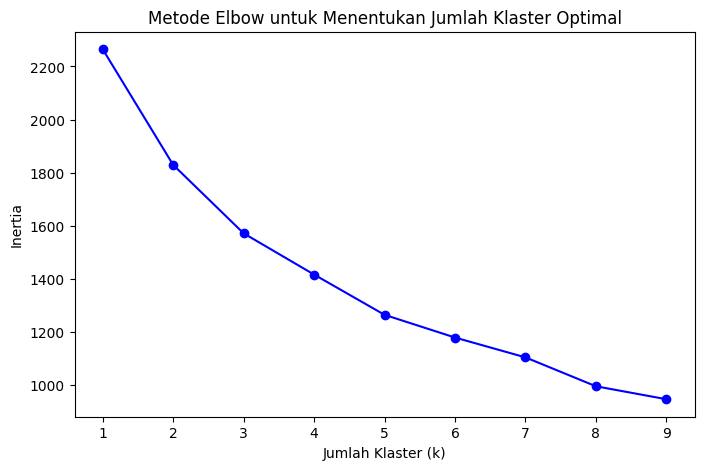

In [ ]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan Jumlah Klaster Optimal')
plt.xticks(K)
plt.show()

# Dari hasil plot, misalkan "elbow" terjadi pada k = 3:
k_optimal = 3

In [ ]:
# Buat copy eksplisit pada gdf_clean
gdf_clean = gdf_clean.copy()

# Terapkan K-Means dan assign nilai cluster menggunakan .loc
gdf_clean.loc[:, 'cluster'] = kmeans.fit_predict(features_scaled)

# Tampilkan hasilnya
print(gdf_clean[['kapal_id', 'latitude', 'longitude', 'intensity', 'cluster']].head())

   kapal_id  latitude   longitude  intensity  cluster
1  IMO-7482 -6.866963  110.306867          9        2
2  IMO-8517 -6.487924  110.411702         17        0
4  IMO-5339 -6.690085  110.480995         11        0
6  IMO-5040 -6.322193  110.359508          6        0
7  IMO-9830 -6.431317  110.412179          3        2


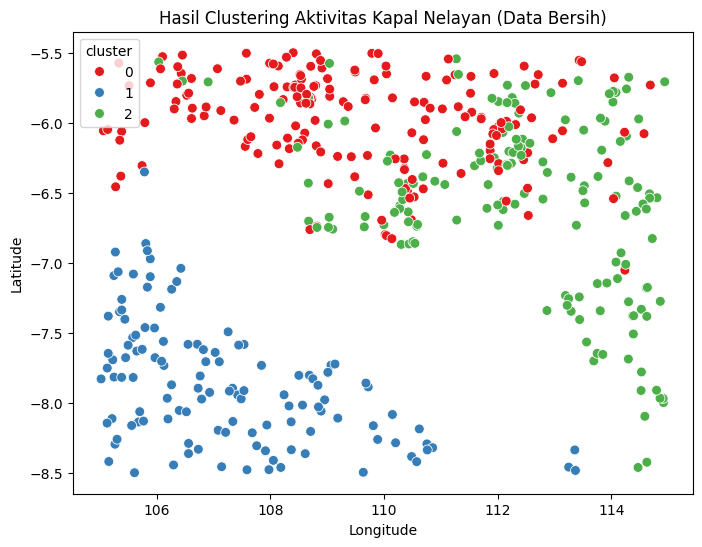

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='longitude', y='latitude', data=gdf_clean, hue='cluster', palette='Set1', s=50)
plt.title('Hasil Clustering Aktivitas Kapal Nelayan (Data Bersih)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Hitung rata-rata intensity untuk masing-masing cluster
cluster_summary = gdf_clean.groupby('cluster')['intensity'].mean().reset_index()
print(cluster_summary)

   cluster  intensity
0        0  11.637931
1        1  10.024390
2        2   7.442308


In [ ]:
# Tentukan titik tengah peta berdasarkan data bersih
map_center = [gdf_clean['latitude'].mean(), gdf_clean['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=8)

# Warna untuk tiap klaster (sesuaikan jika jumlah klaster lebih dari 5)
colors = ['red', 'blue', 'green', 'purple', 'orange']

for idx, row in gdf_clean.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=colors[int(row['cluster']) % len(colors)],
        fill=True,
        fill_color=colors[int(row['cluster']) % len(colors)],
        fill_opacity=0.7,
        popup=f"Kapal: {row['kapal_id']}<br>Intensity: {row['intensity']}<br>Jenis Operasi: {row['jenis_operasi']}"
    ).add_to(m)

# Tampilkan peta interaktif
m

In [17]:
# Simpan dataframe hasil clustering sebagai file CSV
gdf_clean.to_csv('hasil_clustering_clean.csv', index=False)

# Simpan model K-Means menggunakan pickle
import pickle
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

print("Hasil clustering dan model telah disimpan.")

Hasil clustering dan model telah disimpan.
